In [2]:
import pymc3 as pm
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

C:\Users\james\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'norm_pdf' is not defined

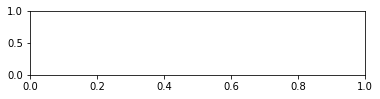

In [3]:
x= np.linspace(0,60000,200)
plt.subplot(311)
sp1=plt.fill_between(x , 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
plt.legend([sp1.get_label()])
plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x , 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")
plt.legend([sp2.get_label()])
plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf(x, 12000, 3000), 
                 color = "#7A68A6", lw = 3, alpha = 0.6,
                 label = "Trip price guess")
plt.legend([sp3.get_label()])

In [ ]:
data_mu = [3e3, 12e3]
data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["true_price"]

In [ ]:
x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
         label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins = 35, normed= True, histtype= "stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.")
plt.legend(loc = "upper left");

In [ ]:
def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss
guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()